In [1]:
import pandas as pd
import numpy as np
import sys
from IPython.display import clear_output

from astropy.io import fits

import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

### Importing Data

In [2]:
df = pd.read_csv('C:/Users/oryan/Documents/mergers-in-cosmos/data/cosmos-matched-all-eazy-df.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (466) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


id_xmm_1',
 'flux_xmm_05_2_1',
 'flux_xmm_2_10_1',
 'flux_xmm_5_10_1',
 'hardness_xmm_1',
 'id_chandra09_1',
 'flux_chandra_05_2_1',
 'flux_chandra_2_10_1',
 'flux_chandra_05_10_1',

In [3]:
df[['id_xmm_1']].dropna()

,id_xmm_1
181,54469.0
549,516.0
627,70096.0
2169,53400.0
2293,60388.0


In [4]:
df[['id_xmm_2']].dropna()

,id_xmm_2


In [5]:
df[['id_chandra09_1']].dropna()

,id_chandra09_1
902,2748.0
1506,1679.0


In [6]:
df[['id_chandra09_2']].dropna()

,id_chandra09_2


Not many detections in XMM or in Chandra throughout this catalogue! I have found a pure AGN catalogue though...

## Importing Catalogue

In [7]:
with fits.open('E:/temporary-cosmos-big-data/VLA_3GHz_counterpart_array_20170210_paper_delvecchio_et_al.fits') as hdul:
    data_delvec = hdul[1].data
    header_delvec = hdul[1].header

In [8]:
del hdul

In [9]:
with fits.open('E:/temporary-cosmos-big-data/chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits') as hdul:
    data_marchesi = hdul[1].data
    header_marchesi = hdul[1].header

In [10]:
del hdul

### Attempting to Match

In [11]:
ra = df.ra_1.iloc[0]
dec = df.dec_1.iloc[0]

In [12]:
mask = (data_delvec['RA_VLA3'] < ra + 0.001) & (data_delvec['RA_VLA3'] > ra - 0.001) & (data_delvec['DEC_VLA3'] < dec + 0.001) & (data_delvec['DEC_VLA3'] > dec - 0.001)

In [13]:
def checking_agn(ra, dec, cat):
    mask = (cat['RA_VLA3'] < ra + 0.001) & (cat['RA_VLA3'] > ra - 0.001) & (cat['DEC_VLA3'] < dec + 0.001) & (cat['DEC_VLA3'] > dec - 0.001)
    column = cat[mask]
    if len(column) > 0.5:
        if len(column['CLASS'][0]) > 0:
            return column['CLASS'][0]
        else:
            return 'no-agn'
    else:
        return 'not-in-cat'

In [14]:
df_check = df[['SourceID', 'ra_1', 'dec_1', 'ra_2', 'dec_2']]

In [15]:
df_checked_delvec = (
    df_check
    .assign(agn_1 = df_check.apply(lambda row: checking_agn(row.ra_1, row.dec_1, data_delvec), axis = 1))
    .assign(agn_2 = df_check.apply(lambda row: checking_agn(row.ra_2, row.dec_2, data_delvec), axis = 1))
)

In [16]:
df_checked_delvec.head()

,SourceID,ra_1,dec_1,ra_2,dec_2,agn_1,agn_2
0,4000705532455,150.679866,2.196563,150.681840,2.195189,not-in-cat,not-in-cat
1,4000705533312,150.668120,2.242867,150.668167,2.243655,no-agn,no-agn
2,4000705533383,150.645145,2.237538,150.644525,2.237836,not-in-cat,not-in-cat
3,4000705539529,149.686238,2.637428,149.687548,2.637165,not-in-cat,not-in-cat
4,4000705539941,149.702477,2.654904,149.702124,2.655957,not-in-cat,not-in-cat


In [17]:
df_checked_delvec.agn_1.value_counts()

not-in-cat    2147
no-agn         262
MLAGN           28
HLAGN           26
Name: agn_1, dtype: int64

In [18]:
df_checked_delvec.agn_2.value_counts()

not-in-cat    2308
no-agn         134
MLAGN           12
HLAGN            9
Name: agn_2, dtype: int64

In [19]:
df_checked_delvec.agn_1.value_counts() + df_checked_delvec.agn_2.value_counts()

not-in-cat    4455
no-agn         396
MLAGN           40
HLAGN           35
dtype: int64

### Exporting the Delvec Catalogue

In [20]:
df_1 = df_checked_delvec[['SourceID', 'ra_1', 'dec_1', 'agn_1']].rename(columns = {'ra_1' :'ra', 'dec_1' : 'dec', 'agn_1' : 'agn'})

In [21]:
df_2 = df_checked_delvec[['SourceID', 'ra_2', 'dec_2', 'agn_2']].rename(columns = {'ra_2' :'ra', 'dec_2' : 'dec', 'agn_2' : 'agn'})

In [22]:
df_1_ren = (
    df_1
    .assign(id_str = df_1.SourceID.apply(lambda x: str(x) + '_1'))
)

df_2_ren = (
    df_2
    .assign(id_str = df_2.SourceID.apply(lambda x: str(x) + '_2'))
)

In [23]:
df_del_exp = pd.concat([df_1_ren, df_2_ren])

In [24]:
df_del_exp.to_csv('C:/Users/oryan/Documents/mergers-in-cosmos/results/delvec-matched-agn-cat.csv')

In [25]:
df_del_exp

,SourceID,ra,dec,agn,id_str
0,4000705532455,150.679866,2.196563,not-in-cat,4000705532455_1
1,4000705533312,150.668120,2.242867,no-agn,4000705533312_1
2,4000705533383,150.645145,2.237538,not-in-cat,4000705533383_1
3,4000705539529,149.686238,2.637428,not-in-cat,4000705539529_1
4,4000705539941,149.702477,2.654904,not-in-cat,4000705539941_1
...,...,...,...,...,...
2458,6000536184828,150.481463,2.607681,not-in-cat,6000536184828_2
2459,6000536185304,150.474007,2.648208,not-in-cat,6000536185304_2
2460,6000536185496,150.498900,2.664859,not-in-cat,6000536185496_2
2461,6000536185585,150.486602,2.670808,not-in-cat,6000536185585_2


### Matching to Chandra COSMOS Legacy

In [26]:
df_remain = pd.concat([df_1_ren, df_2_ren]).query('agn == "not-in-cat"').drop(columns = ['agn'])

In [27]:
df_remain.head()

,SourceID,ra,dec,id_str
0,4000705532455,150.679866,2.196563,4000705532455_1
2,4000705533383,150.645145,2.237538,4000705533383_1
3,4000705539529,149.686238,2.637428,4000705539529_1
4,4000705539941,149.702477,2.654904,4000705539941_1
5,4000705540005,149.722263,2.657249,4000705540005_1


In [28]:
data_marchesi

FITS_rec([('cid_1', 149.63955998, 1.99103389,  10.91, -99.  , -99.  , 1.1799999e-15, -3.9400000e-16, -1.11999999e-14, -99.  ,   0.52, -9.9e+01,  860777, 149.63949585, 1.99103796, 26.06, 0.22, 1, 455942, 149.63951312, 1.99102966, 22.11, 0.03,  860777, 149.63948059, 1.99104798, 22.18, 0.05, 149.63943481, 1.99110794, 21.64, 0.01, 149.63951312, 1.99102966, 21.42, 0.01, 1, 0, 1.928, -99.  , 'None', 0. , -9, 1.928, 3,    -99, 15123.34, 43.229, -42.753, -44.206, -99.  , -99.   , -99.   , -99.   ,  39.2 ,   0.531,  8.1e-02,   0.796, -99.  , -99.   , -99.   , -99.   ),
          ('cid_100', 150.34100998, 2.36716679, 353.08, 284.35,  82.54, 1.4300000e-14,  3.6700002e-15,  9.87999982e-15,  -0.27,  -0.39, -1.3e-01, 1210176, 150.34103394, 2.36718106, 23.62, 0.03, 1, 704286, 150.34106995, 2.36716504, 21.27, 0.01, 1210176, 150.34104919, 2.36715889, 21.31, 0.03, 150.34104919, 2.36712098, 20.85, 0.01, 150.34106995, 2.36716504, 20.59, 0.01, 1, 0, 1.59 ,   1.59, 'VIMOS', 1.5,  1, 1.572, 1,    320, 11920.

Relevant Coords: RA_x, DEC_x

In [29]:
init_dict = {}
names = data_marchesi.names
for i in names:
    init_dict[i] = None

In [30]:
init_dict

{'id_x': None,
 'RA_x': None,
 'DEC_x': None,
 'DET_ML_F': None,
 'DET_ML_S': None,
 'DET_ML_H': None,
 'flux_F': None,
 'flux_S': None,
 'flux_H': None,
 'HR': None,
 'HR_lo_lim': None,
 'HR_up_lim': None,
 'id_i': None,
 'ra_i': None,
 'dec_i': None,
 'i_mag': None,
 'i_mag_err': None,
 'flag_i_mag': None,
 'id_k_uv': None,
 'ra_k_uv': None,
 'dec_k_uv': None,
 'k_uv_mag': None,
 'k_uv_mag_err': None,
 'id_k_cfht': None,
 'ra_k_cfht': None,
 'dec_k_cfht': None,
 'k_cfht_mag': None,
 'k_cfht_mag_err': None,
 'ra_irac': None,
 'dec_irac': None,
 'irac_mag': None,
 'irac_mag_err': None,
 'ra_splash': None,
 'dec_splash': None,
 'splash_mag': None,
 'splash_mag_err': None,
 'final_id_flag': None,
 'star_flag': None,
 'z_best': None,
 'z_spec': None,
 'Instr': None,
 'Qg': None,
 'spec_type': None,
 'z_phot': None,
 'phot_type': None,
 'id_xmm': None,
 'dist_lum': None,
 'Lx_0510': None,
 'Lx_052': None,
 'Lx_210': None,
 'NH': None,
 'abs_corr_0510': None,
 'abs_corr_052': None,
 'abs_co

In [31]:
def checking_agn(ra, dec, cat):
    
    value_dict = {}
    names = cat.names
    for i in names:
        value_dict[i] = None
    
    mask = (cat['RA_x'] < ra + 0.005) & (cat['RA_x'] > ra - 0.005) & (cat['DEC_x'] < dec + 0.005) & (cat['DEC_x'] > dec - 0.005)
    row = cat[mask]
    
    if len(row) > 0.5:
        row = row[0]
        for i in list(value_dict.keys()):
            value_dict[i] = row[i]
        clear_output(wait = True)
        return value_dict
    else:
        clear_output(wait = True)
        return value_dict

In [32]:
match_dict = {}
match_dict = {id_str : checking_agn(df_remain.query('id_str == @id_str').ra.iloc[0], df_remain.query('id_str == @id_str').dec.iloc[0], data_marchesi) for id_str in tqdm(list(df_remain.id_str))}

100%|██████████| 4455/4455 [02:06<00:00, 35.28it/s]


In [33]:
match_df = pd.DataFrame.from_dict(match_dict, orient = 'index').reset_index().drop_duplicates('id_x', keep='first').rename(columns = {'index' : 'id_str'}).dropna()

In [34]:
match_df

,id_str,id_x,RA_x,DEC_x,DET_ML_F,DET_ML_S,DET_ML_H,flux_F,flux_S,flux_H,...,abs_corr_052,abs_corr_210,NH_lo,abs_corr_0510_lo,abs_corr_052_lo,abs_corr_210_lo,NH_up,abs_corr_0510_up,abs_corr_052_up,abs_corr_210_up
8,4000705540519_1,lid_3921,149.693300,2.674050,13.260000,-99.900002,15.440000,1.900000e-15,-3.890000e-16,3.180000e-15,...,-99.000,-99.000,26.299999,0.443,0.016,0.694,-99.000000,-99.000,-99.000,-99.000
13,4000705547180_1,lid_2035,150.320007,2.620354,18.070000,21.129999,-99.900002,3.930000e-15,1.300000e-15,-4.350000e-15,...,1.000,1.000,0.000000,1.000,1.000,1.000,1.760000,0.807,0.519,0.975
14,4000707045178_1,lid_3514,150.224139,1.668515,19.469999,-99.900002,9.010000,2.580000e-15,-7.240000e-16,2.720000e-15,...,-99.000,-99.000,22.100000,0.571,0.110,0.842,-99.000000,-99.000,-99.000,-99.000
15,4000707045688_1,cid_294,150.206911,1.680110,217.789993,76.190002,136.610001,1.140000e-14,1.570000e-15,1.330000e-14,...,0.121,0.863,9.400000,0.617,0.157,0.887,14.700000,0.558,0.088,0.834
21,4000707050156_1,lid_3517,150.246616,1.668289,33.840000,-99.900002,22.110001,3.830000e-15,-8.580000e-16,3.920000e-15,...,0.092,0.800,29.799999,0.595,0.152,0.856,71.599998,0.468,0.042,0.719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4322,6000513983508_2,cid_1189,149.839030,2.407744,49.150002,44.779999,11.270000,3.530000e-15,1.150000e-15,2.060000e-15,...,1.000,1.000,0.000000,1.000,1.000,1.000,0.000000,1.000,1.000,1.000
4332,6000514385546_2,cid_2027,150.518606,2.157731,45.270000,18.809999,25.980000,3.790000e-15,5.720000e-16,4.670000e-15,...,0.130,0.867,9.250000,0.641,0.194,0.904,19.400000,0.543,0.077,0.817
4351,6000518663743_2,cid_490,150.457781,2.062388,69.040001,39.650002,27.559999,5.200000e-15,1.100000e-15,4.670000e-15,...,0.416,0.952,0.000000,1.000,1.000,1.000,19.000000,0.672,0.266,0.911
4355,6000520187548_2,cid_537,150.423309,2.133031,1537.969971,1871.060059,43.630001,5.110000e-14,2.220000e-14,6.380000e-15,...,1.000,1.000,0.000000,1.000,1.000,1.000,0.000000,1.000,1.000,1.000


In [35]:
list(match_df.columns)

['id_str',
 'id_x',
 'RA_x',
 'DEC_x',
 'DET_ML_F',
 'DET_ML_S',
 'DET_ML_H',
 'flux_F',
 'flux_S',
 'flux_H',
 'HR',
 'HR_lo_lim',
 'HR_up_lim',
 'id_i',
 'ra_i',
 'dec_i',
 'i_mag',
 'i_mag_err',
 'flag_i_mag',
 'id_k_uv',
 'ra_k_uv',
 'dec_k_uv',
 'k_uv_mag',
 'k_uv_mag_err',
 'id_k_cfht',
 'ra_k_cfht',
 'dec_k_cfht',
 'k_cfht_mag',
 'k_cfht_mag_err',
 'ra_irac',
 'dec_irac',
 'irac_mag',
 'irac_mag_err',
 'ra_splash',
 'dec_splash',
 'splash_mag',
 'splash_mag_err',
 'final_id_flag',
 'star_flag',
 'z_best',
 'z_spec',
 'Instr',
 'Qg',
 'spec_type',
 'z_phot',
 'phot_type',
 'id_xmm',
 'dist_lum',
 'Lx_0510',
 'Lx_052',
 'Lx_210',
 'NH',
 'abs_corr_0510',
 'abs_corr_052',
 'abs_corr_210',
 'NH_lo',
 'abs_corr_0510_lo',
 'abs_corr_052_lo',
 'abs_corr_210_lo',
 'NH_up',
 'abs_corr_0510_up',
 'abs_corr_052_up',
 'abs_corr_210_up']

In [36]:
len(match_df.query('HR > -99'))

391

Text(0.5, 1.0, '')

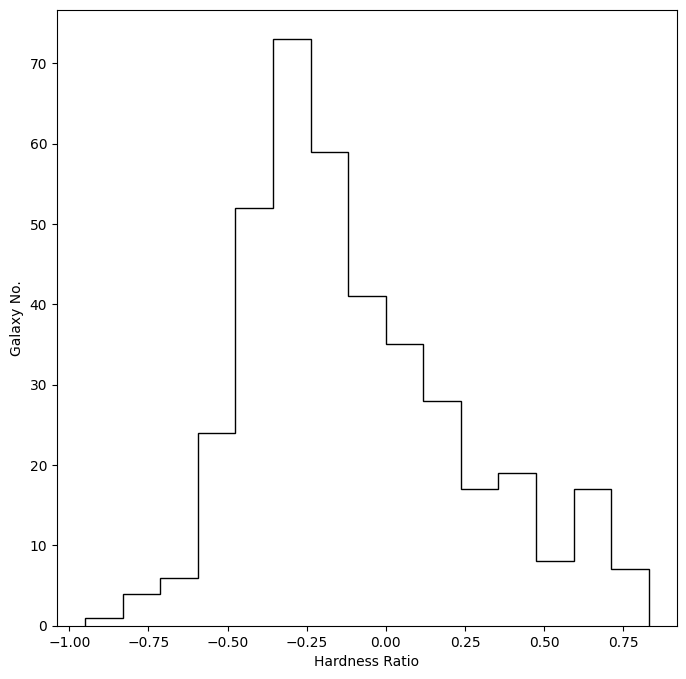

In [37]:
match_df.query('HR > -99').hist(
    column = ['HR'],
    bins = 15,
    grid = False,
    histtype = 'step',
    color='black',
    figsize = (8,8),
)
plt.ylabel('Galaxy No.')
plt.xlabel('Hardness Ratio')
plt.title('')

In [38]:
export_df = match_df.query('HR > -99')

In [40]:
export_df.to_csv('C:/Users/oryan/Documents/mergers-in-cosmos/results/marchesi-matched-hr-cat.csv')

### Correcting For Obscuration

In [41]:
obs_df = (
    export_df
    .assign(obscured = export_df.HR.apply(lambda x: 'obscured' if x > -0.2 else 'unobscured'))
)

In [42]:
obs_df.obscured.value_counts()

obscured      208
unobscured    183
Name: obscured, dtype: int64

In [43]:
obs_df.spec_type.value_counts()

-9.0     132
 2.0     128
 1.0      85
-99.0     34
-1.0      10
 0.0       2
Name: spec_type, dtype: int64

In [44]:
# obs_df.query('spec_type == 1.0').to_csv('C:/Users/oryan/Documents/mergers-in-cosmos/results/cosmos-multiwave-blagn-unmatched.csv')

In [45]:
# obs_df.query('spec_type == 2.0').to_csv('C:/Users/oryan/Documents/mergers-in-cosmos/results/cosmos-multiwave-non-blagn-unmatched.csv')

In [46]:
obs_df.columns

Index(['id_str', 'id_x', 'RA_x', 'DEC_x', 'DET_ML_F', 'DET_ML_S', 'DET_ML_H',
       'flux_F', 'flux_S', 'flux_H', 'HR', 'HR_lo_lim', 'HR_up_lim', 'id_i',
       'ra_i', 'dec_i', 'i_mag', 'i_mag_err', 'flag_i_mag', 'id_k_uv',
       'ra_k_uv', 'dec_k_uv', 'k_uv_mag', 'k_uv_mag_err', 'id_k_cfht',
       'ra_k_cfht', 'dec_k_cfht', 'k_cfht_mag', 'k_cfht_mag_err', 'ra_irac',
       'dec_irac', 'irac_mag', 'irac_mag_err', 'ra_splash', 'dec_splash',
       'splash_mag', 'splash_mag_err', 'final_id_flag', 'star_flag', 'z_best',
       'z_spec', 'Instr', 'Qg', 'spec_type', 'z_phot', 'phot_type', 'id_xmm',
       'dist_lum', 'Lx_0510', 'Lx_052', 'Lx_210', 'NH', 'abs_corr_0510',
       'abs_corr_052', 'abs_corr_210', 'NH_lo', 'abs_corr_0510_lo',
       'abs_corr_052_lo', 'abs_corr_210_lo', 'NH_up', 'abs_corr_0510_up',
       'abs_corr_052_up', 'abs_corr_210_up', 'obscured'],
      dtype='object')

In [47]:
unknown_df = obs_df.query('spec_type != 0.0')

In [48]:
unknown_df

,id_str,id_x,RA_x,DEC_x,DET_ML_F,DET_ML_S,DET_ML_H,flux_F,flux_S,flux_H,...,abs_corr_210,NH_lo,abs_corr_0510_lo,abs_corr_052_lo,abs_corr_210_lo,NH_up,abs_corr_0510_up,abs_corr_052_up,abs_corr_210_up,obscured
13,4000705547180_1,lid_2035,150.320007,2.620354,18.070000,21.129999,-99.900002,3.930000e-15,1.300000e-15,-4.350000e-15,...,1.000,0.000000,1.000,1.000,1.000,1.760000,0.807,0.519,0.975,unobscured
15,4000707045688_1,cid_294,150.206911,1.680110,217.789993,76.190002,136.610001,1.140000e-14,1.570000e-15,1.330000e-14,...,0.863,9.400000,0.617,0.157,0.887,14.700000,0.558,0.088,0.834,obscured
21,4000707050156_1,lid_3517,150.246616,1.668289,33.840000,-99.900002,22.110001,3.830000e-15,-8.580000e-16,3.920000e-15,...,0.800,29.799999,0.595,0.152,0.856,71.599998,0.468,0.042,0.719,obscured
23,4000708130472_1,cid_232,149.988640,1.908585,161.119995,99.959999,48.250000,8.200000e-15,1.910000e-15,6.840000e-15,...,0.972,0.000000,1.000,1.000,1.000,0.980000,0.716,0.321,0.945,obscured
35,4000713396810_1,cid_1150,150.024420,2.232964,29.870001,29.559999,-99.000000,1.930000e-15,5.660000e-16,-8.479999e-15,...,1.000,0.000000,1.000,1.000,1.000,13.300000,0.651,0.219,0.906,unobscured
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,6000443107217_2,cid_1233,149.765661,2.527757,2836.860107,1913.420044,1034.339966,8.710000e-14,2.190000e-14,6.900000e-14,...,0.957,7.210000,0.793,0.500,0.965,10.400000,0.752,0.415,0.951,obscured
4322,6000513983508_2,cid_1189,149.839030,2.407744,49.150002,44.779999,11.270000,3.530000e-15,1.150000e-15,2.060000e-15,...,1.000,0.000000,1.000,1.000,1.000,0.000000,1.000,1.000,1.000,unobscured
4332,6000514385546_2,cid_2027,150.518606,2.157731,45.270000,18.809999,25.980000,3.790000e-15,5.720000e-16,4.670000e-15,...,0.867,9.250000,0.641,0.194,0.904,19.400000,0.543,0.077,0.817,obscured
4351,6000518663743_2,cid_490,150.457781,2.062388,69.040001,39.650002,27.559999,5.200000e-15,1.100000e-15,4.670000e-15,...,0.952,0.000000,1.000,1.000,1.000,19.000000,0.672,0.266,0.911,obscured


In [49]:
df_agn_lum = (
    unknown_df[['id_str', 'id_x', 'z_best', 'dist_lum', 'Lx_0510', 'Lx_052', 'Lx_210', 'NH', 'abs_corr_0510', 'abs_corr_052', 'abs_corr_210', 'obscured']]
    .query('z_best > -99')
)

In [50]:
corrected_df = (
    df_agn_lum
    .assign(Lx_0510_corr = df_agn_lum.apply(lambda row: abs(np.log10((10**row.Lx_0510) / row.abs_corr_0510)), axis = 1))
    .assign(Lx_052_corr = df_agn_lum.apply(lambda row: abs(np.log10((10**row.Lx_052) / row.abs_corr_052)), axis = 1))
    .assign(Lx_210_corr = df_agn_lum.apply(lambda row: abs(np.log10((10**row.Lx_210) / row.abs_corr_210)), axis = 1))
)

In [51]:
corrected_df

,id_str,id_x,z_best,dist_lum,Lx_0510,Lx_052,Lx_210,NH,abs_corr_0510,abs_corr_052,abs_corr_210,obscured,Lx_0510_corr,Lx_052_corr,Lx_210_corr
13,4000705547180_1,lid_2035,1.048,7103.520020,43.188000,42.708000,-43.233002,0.000000,1.000,1.000,1.000,unobscured,43.188000,42.708000,43.233002
15,4000707045688_1,cid_294,1.110,7629.540039,43.705002,42.844002,43.771999,11.700000,0.589,0.121,0.863,obscured,43.934887,43.761216,43.835989
21,4000707050156_1,lid_3517,2.158,17368.410156,43.841000,-43.191002,43.851002,44.700001,0.538,0.092,0.800,obscured,44.110217,42.154790,43.947912
23,4000708130472_1,cid_232,0.165,797.640015,41.756001,41.123001,41.676998,0.490000,0.798,0.497,0.972,obscured,41.853998,41.426645,41.689332
35,4000713396810_1,cid_1150,1.697,12920.709961,43.327999,42.794998,-43.970001,0.000000,1.000,1.000,1.000,unobscured,43.327999,42.794998,43.970001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,6000443107217_2,cid_1233,2.412,19899.330078,45.296001,44.695999,45.195000,8.990000,0.769,0.449,0.957,obscured,45.410075,45.043753,45.214088
4322,6000513983508_2,cid_1189,0.733,4563.169922,42.800999,42.313999,42.567001,0.000000,1.000,1.000,1.000,unobscured,42.800999,42.313999,42.567001
4332,6000514385546_2,cid_2027,1.259,8922.900391,43.345001,42.523998,43.436001,13.300000,0.594,0.130,0.867,obscured,43.571215,43.410055,43.497982
4351,6000518663743_2,cid_490,2.325,19026.789062,44.040001,43.365002,43.993000,9.680000,0.753,0.416,0.952,obscured,44.163206,43.745908,44.014363


In [52]:
agn_df = (
    corrected_df
    .assign(agn = corrected_df.Lx_210_corr.apply(lambda x: 'agn' if 10**x >= 3e42 else 'non-agn'))
    .query('Lx_210_corr < 80')
)

In [53]:
agn_df.agn.value_counts()

agn        356
non-agn     28
Name: agn, dtype: int64

In [54]:
agn_df.to_csv('C:/Users/oryan/Documents/mergers-in-cosmos/results/cosmos-multiwave-calc-agn-unmatched.csv')

### Checking Completeness

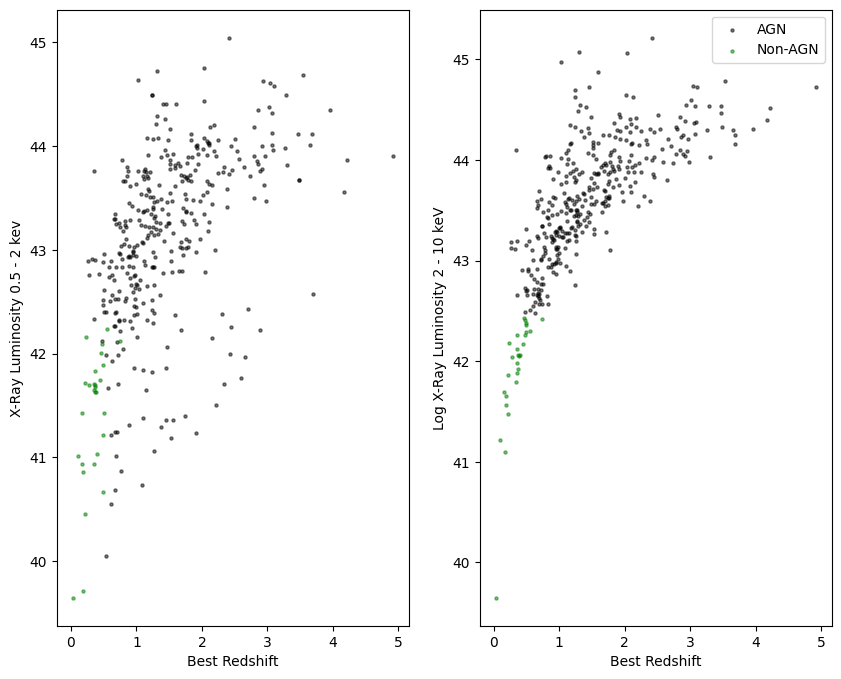

In [55]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,8))
agn_df.query('agn == "agn"').plot.scatter(
    x = 'z_best',
    y = 'Lx_052_corr',
    color = 'black',
    s = 5,
    alpha = 0.5,
    ax = ax[0],
)
agn_df.query('agn == "non-agn"').plot.scatter(
    x = 'z_best',
    y = 'Lx_052_corr',
    color = 'green',
    s = 5,
    alpha = 0.5,
    ax = ax[0],
    xlabel = 'Best Redshift',
    ylabel = 'X-Ray Luminosity 0.5 - 2 kev'
)


agn_df.query('agn == "agn"').plot.scatter(
    x = 'z_best',
    y = 'Lx_210_corr',
    color = 'black',
    s = 5,
    alpha = 0.5,
    ax = ax[1],
    label = 'AGN'
)
agn_df.query('agn == "non-agn"').plot.scatter(
    x = 'z_best',
    y = 'Lx_210_corr',
    color = 'green',
    s = 5,
    alpha = 0.5,
    ax = ax[1],
    xlabel = 'Best Redshift',
    ylabel = 'Log X-Ray Luminosity 2 - 10 keV',
    label = 'Non-AGN'
)
plt.show()